In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
import random

seed = 77
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

import zipfile
with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
   # Extract all the contents of zip file in current directory
   zip_obj.extractall('/kaggle/working/')
    
print('After zip extraction:')
print(os.listdir("/kaggle/working/"))

['sample_submission.csv', 'plates.zip']
After zip extraction:
['plates', '__MACOSX', '__notebook__.ipynb']


# Unpack data

In [2]:
data_root = '/kaggle/working/plates/'
print(os.listdir(data_root))

['train', '.DS_Store', 'test']


In [3]:
#data_root = '../input/plates/plates/'
#print(os.listdir(data_root))
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0: #Создаем папку train и val (из папки train берем каждую шестую на валидацию)
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 4778.15it/s]


In [4]:
!ls train

cleaned  dirty


In [5]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models
train_transforms = [transforms.Compose([
    transforms.CenterCrop(200),#RandomResizedCrop(224)
    transforms.Resize((224,224)),#
    transforms.RandomRotation(10),#
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),#hue 0.2
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#Транформация нормировки. Изображения привести к виду, на котором обучался изначальный ResNet. Вычетаем от красного, зелёного и синего константы 0.485, 0.456, 0.406 и делим на 0.229, 0.224, 0.225 (данные из мануала ResNet)
])
,
 transforms.Compose([
    transforms.RandomRotation(45),
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                    
 transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.4, saturation=0.4, hue=0.4),# br =0.2
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                    
transforms.Compose([
    transforms.CenterCrop(140),
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(), 
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])  ,
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomGrayscale(p=1),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                    
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.RandomOrder([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
        ]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    
    transforms.Compose([
    transforms.CenterCrop(200),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
]


val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(train_dir,train_transform)
                                                    for train_transform in train_transforms])

val_dataset = torch.utils.data.ConcatDataset([torchvision.datasets.ImageFolder(val_dir,train_transform)
                                                    for train_transform in train_transforms])

#train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms) #без аргумента train transforms будут не pytorch тензоры
#val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 4#6#8 
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [6]:
len(train_dataloader), len(train_dataset)

(56, 224)

In [7]:
len(val_dataloader), len(val_dataset)

(14, 56)

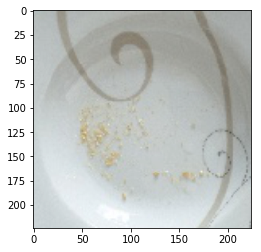

In [8]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

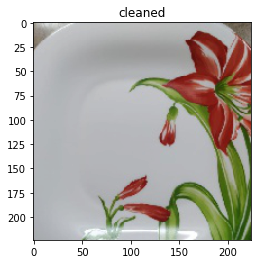

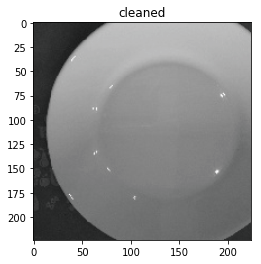

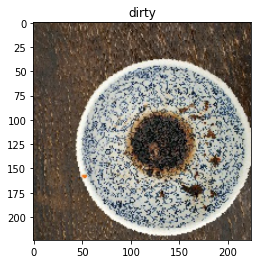

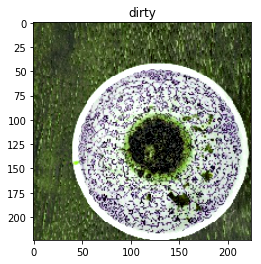

In [9]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy() #обратная операция к ToTensor - .permute(1, 2, 0) Channels,H,W -> H,W,Channels потом превращаем в numpy array .numpy()
    image = std * image + mean #Делаем обратную трансформацию нормировки
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [10]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    train_loss = torch.zeros(num_epochs)
    val_loss = torch.zeros(num_epochs)
    train_acc = torch.zeros(num_epochs)
    val_acc = torch.zeros(num_epochs)
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader
                scheduler.step() #Делаем 1 шаг (произошла одна эпоха)
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1) # Получаем класс,берем .argmax(dim=1) нейрон с максимальной активацией

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader) # Loss'ы делим на кол-во бачей в эпохе 
            epoch_acc = running_acc / len(dataloader)
            if phase == 'train':
                train_loss[epoch] = epoch_loss
                train_acc[epoch] = epoch_acc
            else:
                val_loss[epoch] = epoch_loss
                val_acc[epoch] = epoch_acc

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return train_loss, val_loss, train_acc, val_acc

In [11]:
model = models.resnet50(pretrained=True)

# Disable grad for all conv layers
for param in model.parameters():
    param.requires_grad = False

#model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.fc = torch.nn.Sequential(
    torch.nn.Linear(model.fc.in_features, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.Sigmoid(), #torch.nn.ReLU(),
    torch.nn.Linear(256, 2)
)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

loss = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-4) #-4 the best
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum = 0.9)
# Decay LR by a factor of 0.1 every 4 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.4)#step size & gamma

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:00<00:00, 147706049.68it/s]


In [12]:
train_loss, val_loss, train_acc, val_acc = train_model(model, loss, optimizer, scheduler, num_epochs=37)
                                                      
                                                     

Epoch 0/36:


100%|██████████| 56/56 [00:01<00:00, 27.60it/s]

train Loss: 0.6004 Acc: 0.6741



100%|██████████| 14/14 [00:00<00:00, 30.58it/s]

val Loss: 0.5441 Acc: 0.7500
Epoch 1/36:



100%|██████████| 56/56 [00:01<00:00, 41.22it/s]

train Loss: 0.4569 Acc: 0.8438



100%|██████████| 14/14 [00:00<00:00, 31.00it/s]

val Loss: 0.5337 Acc: 0.6786
Epoch 2/36:



100%|██████████| 56/56 [00:01<00:00, 41.67it/s]

train Loss: 0.4219 Acc: 0.8527



100%|██████████| 14/14 [00:00<00:00, 30.27it/s]

val Loss: 0.4852 Acc: 0.8036
Epoch 3/36:



100%|██████████| 56/56 [00:01<00:00, 42.01it/s]

train Loss: 0.3984 Acc: 0.8884



100%|██████████| 14/14 [00:00<00:00, 30.41it/s]

val Loss: 0.4771 Acc: 0.8036
Epoch 4/36:



100%|██████████| 56/56 [00:01<00:00, 42.10it/s]

train Loss: 0.3974 Acc: 0.8661



100%|██████████| 14/14 [00:00<00:00, 30.72it/s]

val Loss: 0.4696 Acc: 0.8393
Epoch 5/36:



100%|██████████| 56/56 [00:01<00:00, 42.47it/s]

train Loss: 0.3562 Acc: 0.8973



100%|██████████| 14/14 [00:00<00:00, 27.70it/s]

val Loss: 0.4575 Acc: 0.8393
Epoch 6/36:



100%|██████████| 56/56 [00:01<00:00, 41.39it/s]

train Loss: 0.3526 Acc: 0.8929



100%|██████████| 14/14 [00:00<00:00, 30.90it/s]

val Loss: 0.4550 Acc: 0.8214
Epoch 7/36:



100%|██████████| 56/56 [00:01<00:00, 42.62it/s]

train Loss: 0.3763 Acc: 0.8973



100%|██████████| 14/14 [00:00<00:00, 30.44it/s]

val Loss: 0.4706 Acc: 0.8214
Epoch 8/36:



100%|██████████| 56/56 [00:01<00:00, 41.60it/s]

train Loss: 0.4002 Acc: 0.8527



100%|██████████| 14/14 [00:00<00:00, 30.44it/s]

val Loss: 0.4390 Acc: 0.8393
Epoch 9/36:



100%|██████████| 56/56 [00:01<00:00, 41.55it/s]

train Loss: 0.4042 Acc: 0.8571



100%|██████████| 14/14 [00:00<00:00, 30.79it/s]

val Loss: 0.4569 Acc: 0.7679
Epoch 10/36:



100%|██████████| 56/56 [00:01<00:00, 42.28it/s]

train Loss: 0.3507 Acc: 0.9063



100%|██████████| 14/14 [00:00<00:00, 29.76it/s]

val Loss: 0.4521 Acc: 0.7857
Epoch 11/36:



100%|██████████| 56/56 [00:01<00:00, 40.31it/s]

train Loss: 0.3126 Acc: 0.9375



100%|██████████| 14/14 [00:00<00:00, 25.99it/s]

val Loss: 0.4620 Acc: 0.8393
Epoch 12/36:



100%|██████████| 56/56 [00:01<00:00, 39.75it/s]

train Loss: 0.3310 Acc: 0.9330



100%|██████████| 14/14 [00:00<00:00, 30.49it/s]

val Loss: 0.4375 Acc: 0.8571
Epoch 13/36:



100%|██████████| 56/56 [00:01<00:00, 41.72it/s]

train Loss: 0.3739 Acc: 0.8839



100%|██████████| 14/14 [00:00<00:00, 30.49it/s]

val Loss: 0.4544 Acc: 0.8214
Epoch 14/36:



100%|██████████| 56/56 [00:01<00:00, 41.99it/s]

train Loss: 0.3410 Acc: 0.9063



100%|██████████| 14/14 [00:00<00:00, 30.73it/s]

val Loss: 0.4171 Acc: 0.8571
Epoch 15/36:



100%|██████████| 56/56 [00:01<00:00, 41.90it/s]

train Loss: 0.3593 Acc: 0.8973



100%|██████████| 14/14 [00:00<00:00, 31.00it/s]

val Loss: 0.4449 Acc: 0.8929
Epoch 16/36:



100%|██████████| 56/56 [00:01<00:00, 41.00it/s]

train Loss: 0.3836 Acc: 0.8616



100%|██████████| 14/14 [00:00<00:00, 29.39it/s]

val Loss: 0.4519 Acc: 0.7679
Epoch 17/36:



100%|██████████| 56/56 [00:01<00:00, 42.28it/s]

train Loss: 0.3608 Acc: 0.8839



100%|██████████| 14/14 [00:00<00:00, 30.60it/s]

val Loss: 0.4723 Acc: 0.8750
Epoch 18/36:



100%|██████████| 56/56 [00:01<00:00, 41.62it/s]

train Loss: 0.3320 Acc: 0.9018



100%|██████████| 14/14 [00:00<00:00, 30.35it/s]

val Loss: 0.4758 Acc: 0.8393
Epoch 19/36:



100%|██████████| 56/56 [00:01<00:00, 41.39it/s]

train Loss: 0.3677 Acc: 0.9018



100%|██████████| 14/14 [00:00<00:00, 30.51it/s]

val Loss: 0.4417 Acc: 0.8214
Epoch 20/36:



100%|██████████| 56/56 [00:01<00:00, 40.61it/s]

train Loss: 0.4062 Acc: 0.8616



100%|██████████| 14/14 [00:00<00:00, 30.74it/s]

val Loss: 0.5030 Acc: 0.7500
Epoch 21/36:



100%|██████████| 56/56 [00:01<00:00, 41.58it/s]

train Loss: 0.3473 Acc: 0.8884



100%|██████████| 14/14 [00:00<00:00, 30.47it/s]

val Loss: 0.4926 Acc: 0.7679
Epoch 22/36:



100%|██████████| 56/56 [00:01<00:00, 40.89it/s]

train Loss: 0.3605 Acc: 0.8884



100%|██████████| 14/14 [00:00<00:00, 30.73it/s]

val Loss: 0.4178 Acc: 0.8393
Epoch 23/36:



100%|██████████| 56/56 [00:01<00:00, 41.46it/s]

train Loss: 0.3903 Acc: 0.8616



100%|██████████| 14/14 [00:00<00:00, 30.54it/s]

val Loss: 0.4255 Acc: 0.8393
Epoch 24/36:



100%|██████████| 56/56 [00:01<00:00, 41.79it/s]

train Loss: 0.3550 Acc: 0.9018



100%|██████████| 14/14 [00:00<00:00, 30.36it/s]

val Loss: 0.4557 Acc: 0.8036
Epoch 25/36:



100%|██████████| 56/56 [00:01<00:00, 41.66it/s]

train Loss: 0.3492 Acc: 0.9152



100%|██████████| 14/14 [00:00<00:00, 29.79it/s]

val Loss: 0.4487 Acc: 0.8393
Epoch 26/36:



100%|██████████| 56/56 [00:01<00:00, 41.59it/s]

train Loss: 0.3519 Acc: 0.9018



100%|██████████| 14/14 [00:00<00:00, 29.91it/s]

val Loss: 0.4368 Acc: 0.8393
Epoch 27/36:



100%|██████████| 56/56 [00:01<00:00, 41.26it/s]

train Loss: 0.3530 Acc: 0.8973



100%|██████████| 14/14 [00:00<00:00, 29.38it/s]

val Loss: 0.4435 Acc: 0.8214
Epoch 28/36:



100%|██████████| 56/56 [00:01<00:00, 41.62it/s]

train Loss: 0.3748 Acc: 0.8705



100%|██████████| 14/14 [00:00<00:00, 25.76it/s]

val Loss: 0.4716 Acc: 0.8214
Epoch 29/36:



100%|██████████| 56/56 [00:01<00:00, 39.59it/s]

train Loss: 0.3774 Acc: 0.8750



100%|██████████| 14/14 [00:00<00:00, 30.39it/s]

val Loss: 0.4814 Acc: 0.7857
Epoch 30/36:



100%|██████████| 56/56 [00:01<00:00, 41.90it/s]

train Loss: 0.3539 Acc: 0.8750



100%|██████████| 14/14 [00:00<00:00, 30.94it/s]

val Loss: 0.4438 Acc: 0.7679
Epoch 31/36:



100%|██████████| 56/56 [00:01<00:00, 41.78it/s]

train Loss: 0.3722 Acc: 0.8839



100%|██████████| 14/14 [00:00<00:00, 30.75it/s]

val Loss: 0.4462 Acc: 0.8214
Epoch 32/36:



100%|██████████| 56/56 [00:01<00:00, 41.76it/s]

train Loss: 0.3613 Acc: 0.8705



100%|██████████| 14/14 [00:00<00:00, 27.48it/s]

val Loss: 0.4347 Acc: 0.8214
Epoch 33/36:



100%|██████████| 56/56 [00:01<00:00, 41.74it/s]

train Loss: 0.3623 Acc: 0.8750



100%|██████████| 14/14 [00:00<00:00, 30.96it/s]

val Loss: 0.4415 Acc: 0.8036
Epoch 34/36:



100%|██████████| 56/56 [00:01<00:00, 41.88it/s]

train Loss: 0.3660 Acc: 0.8929



100%|██████████| 14/14 [00:00<00:00, 30.92it/s]

val Loss: 0.4531 Acc: 0.8571
Epoch 35/36:



100%|██████████| 56/56 [00:01<00:00, 41.90it/s]

train Loss: 0.3561 Acc: 0.8795



100%|██████████| 14/14 [00:00<00:00, 30.52it/s]

val Loss: 0.4402 Acc: 0.8393
Epoch 36/36:



100%|██████████| 56/56 [00:01<00:00, 42.07it/s]

train Loss: 0.3657 Acc: 0.8795



100%|██████████| 14/14 [00:00<00:00, 30.80it/s]

val Loss: 0.4161 Acc: 0.8571


In [13]:
train_loss = train_loss.numpy()
val_loss = val_loss.numpy()
train_acc = train_acc.numpy()
val_acc = val_acc.numpy()

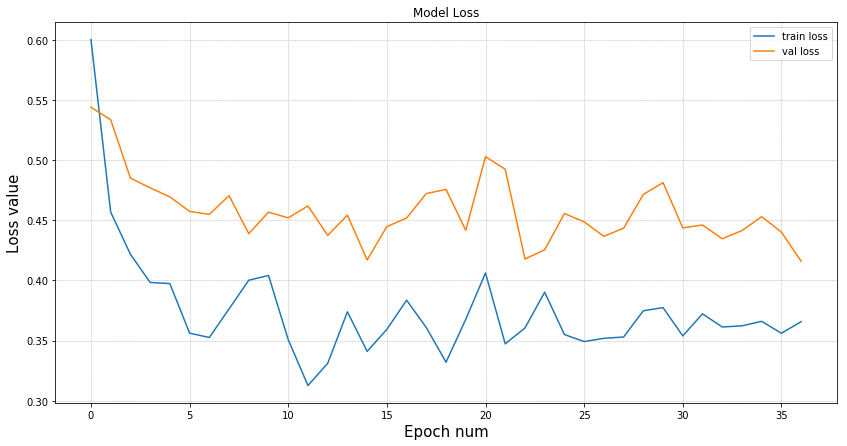

In [14]:
plt.rcParams['figure.figsize'] = (14, 7)
plt.plot(train_loss, label = 'train loss')
plt.plot(val_loss, label = 'val loss')
plt.legend(loc='best')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7')


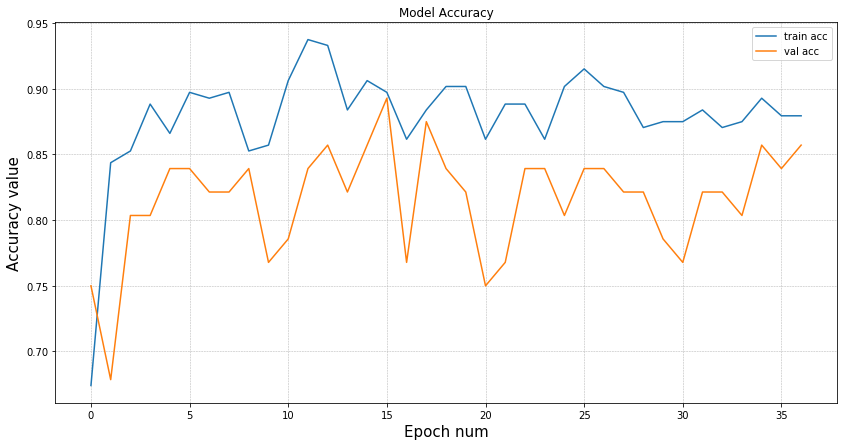

In [15]:
plt.rcParams['figure.figsize'] = (14, 7)
plt.plot(train_acc, label = 'train acc')
plt.plot(val_acc, label = 'val acc')
plt.legend(loc='best')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15);
plt.grid(linestyle='--', linewidth=0.5, color='.7') 


In [16]:
#Костыль ImageFolder, который не может обработать путь к папке в которой уже сразу лежат изображения
#Копируем всю папку test в директорию test\unknown
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

'test/unknown'

In [17]:

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/kaggle/working/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [18]:
test_dataset

Dataset ImageFolderWithPaths
    Number of datapoints: 744
    Root location: /kaggle/working/test

In [19]:
model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy()) #[:,1]берем только вероятность для первого класса
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 186/186 [00:06<00:00, 31.06it/s]


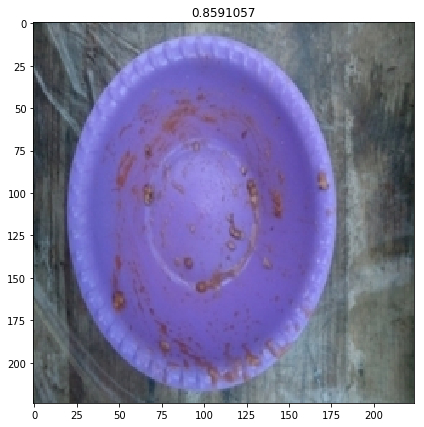

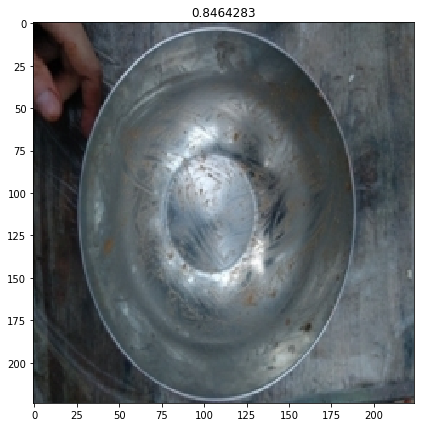

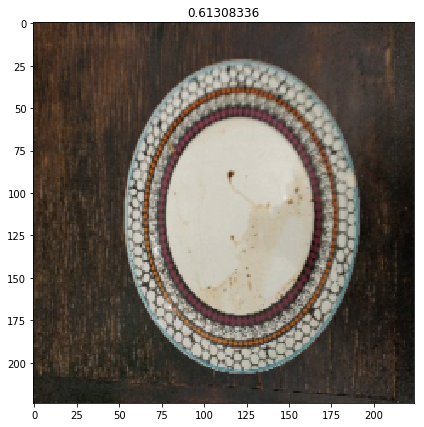

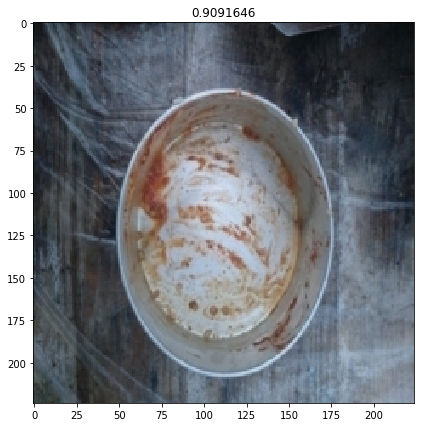

In [20]:

inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [21]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [22]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.6 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

,label
id,
0000,dirty
0001,dirty
0002,dirty
0003,dirty
0004,dirty
0005,dirty


In [23]:
submission_df.to_csv('submission.csv')

In [24]:
!rm -rf train val test #чистим папки